# Time-series plotting (Optional)

In all of the sections thus far our visualizations have focused on and used numeric variables: either categorical variables, which fall into a set of buckets, or interval variables, which fall into an interval of values. In this notebook we will explore another type of variable: a time-series variable.

In [1]:
import pandas as pd
pd.set_option('max_columns', None)
import numpy as np

## Types of time series variables

Time-series variables are populated by values which are specific to a point in time. Time is linear and infinitely fine-grained, so really time-series values are a kind of special case of interval variables.

Dates can show up in your dataset in a few different ways. We'll examine the two most common ways in this notebook.

In the "strong case" dates act as an explicit index on your dataset. A good example is the following dataset on stock prices:

In [2]:
stocks = pd.read_csv("../input/nyse/prices.csv", parse_dates=['date'])
stocks = stocks[stocks['symbol'] == "GOOG"].set_index('date')
stocks.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,GOOG,626.951088,626.751061,624.241073,629.511067,3927000.0
2010-01-05,GOOG,627.181073,623.991055,621.541045,627.841071,6031900.0
2010-01-06,GOOG,625.861078,608.261023,606.361042,625.861078,7987100.0
2010-01-07,GOOG,609.401025,594.101005,592.651008,610.001045,12876600.0
2010-01-08,GOOG,592.000997,602.021036,589.110988,603.251034,9483900.0


This dataset which is indexed by the date: the data being collected is being collected in the "period" of a day. The values in the record provide information about that stock within that period.

For daily data like this using a date like this is convenient. But a period can technically be for any length of time. `pandas` provides a whole dedicated type, the `pandas.Period` `dtype` (documented [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Period.html)), for this concept.

In the "weak case", dates act as timestamps: they tell us something about when an observation occurred. For example, in the following dataset of animal shelter outcomes, there are two columns, `datetime` and `date_of_birth`, which describe facts about the animal in the observation.

In [3]:
shelter_outcomes = pd.read_csv(
    "../input/austin-animal-center-shelter-outcomes-and/aac_shelter_outcomes.csv", 
    parse_dates=['date_of_birth', 'datetime']
)
shelter_outcomes = shelter_outcomes[
    ['outcome_type', 'age_upon_outcome', 'datetime', 'animal_type', 'breed', 
     'color', 'sex_upon_outcome', 'date_of_birth']
]
shelter_outcomes.head()

,outcome_type,age_upon_outcome,datetime,animal_type,breed,color,sex_upon_outcome,date_of_birth
0,Transfer,2 weeks,2014-07-22 16:04:00,Cat,Domestic Shorthair Mix,Orange Tabby,Intact Male,2014-07-07
1,Transfer,1 year,2013-11-07 11:47:00,Dog,Beagle Mix,White/Brown,Spayed Female,2012-11-06
2,Adoption,1 year,2014-06-03 14:20:00,Dog,Pit Bull,Blue/White,Neutered Male,2013-03-31
3,Transfer,9 years,2014-06-15 15:50:00,Dog,Miniature Schnauzer Mix,White,Neutered Male,2005-06-02
4,Euthanasia,5 months,2014-07-07 14:04:00,Other,Bat Mix,Brown,Unknown,2014-01-07


To put this another way, the stock data is aggregated over a certain period of time, so changing the time significantly changes the data. In the animal outcomes case, information is "record-level"; the dates are descriptive facts and it doesn't make sense to change them.

## Visualizing by grouping

I said earlier that time is a "special case" of an interval variable. Does that mean that we can use the tools and techniques familiar to us from earlier sections with time series data as well? Of course!

For example, here's a line plot visualizing which birth dates are the most common in the dataset.

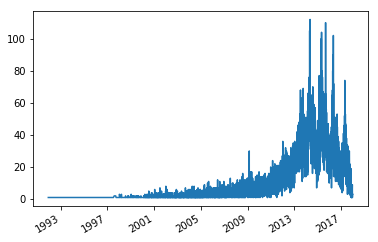

In [4]:
shelter_outcomes['date_of_birth'].value_counts().sort_values().plot.line()

It looks like birth dates for the animals in the dataset peak at around 2015, but it's hard to tell for sure because the data is rather noisy.

Currently the data is by day, but what if we globbed all the dates together into years? This is known as **resampling**. We can do this to tweak the dataset, generating a result that's aggregated by year. The method for doing this in `pandas`, `resample`, is pretty simple. There are lots of potential resampling options: we'll use `Y`, which is short for "year".

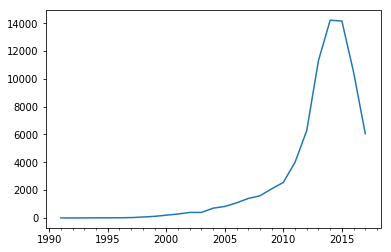

In [5]:
shelter_outcomes['date_of_birth'].value_counts().resample('Y').sum().plot.line()

Much clearer! It looks like, actually, 2014 and 2015 have an almost equal presence in the dataset.

This demonstrates the data visualization benefit of resampling: by choosing certain periods you can more clearly visualize certain aspects of the dataset.

Notice that `pandas` is automatically adapting the labels on the x-axis to match our output type. This is because `pandas` is "datetime-aware"; it knows that when we have data points spaced out one year apart from one another, we only want to see the years in the labels, and nothing else!

Usually the value of time-series data is exposed through this sort of grouping. For example, here's a similar simple bar chart which looks at the trade volume of the `GOOG` stock:

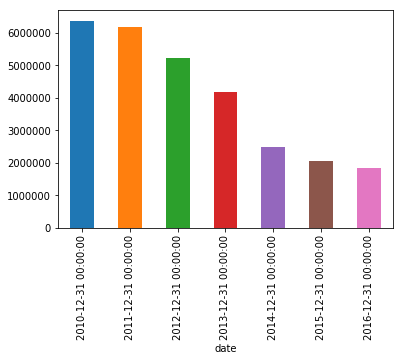

In [6]:
stocks['volume'].resample('Y').mean().plot.bar()

Most of the "new stuff" to using dates in your visualization comes down to a handful of new data processing techniques. Because timestampls are "just" interval variables, understanding date-time data don't require any newfangled visualization techniques!

## Some new plot types

### Lag plot

One of these plot types is the lag plot. A lag plot compares data points from each observation in the dataset against data points from a previous observation. So for example, data from December 21st will be compared with data from December 20th, which will in turn be compared with data from December 19th, and so on. For example, here is what we see when we apply a lag plot to the volume (number of trades conducted) in the stock data:

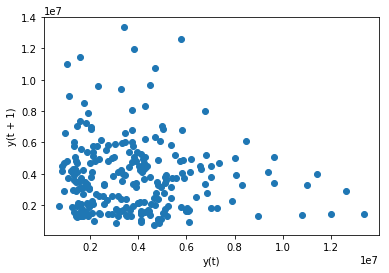

In [7]:
from pandas.plotting import lag_plot

lag_plot(stocks['volume'].sample(250))

It looks like days when volume is high are only very loosely correlated with one another. In other words, a day of frantic trading does not necessarily signal that the next day will also involve frantic trading. In fact, there seem to be quite a few days of *extremely* high trading activity which stand out all alone!

Time-series data tends to exhibit a behavior called **periodicity**: rises and peaks in the data that are correlated with time. For example, a gym would likely see an increase in attendance at the end of every workday, hence exhibiting a periodicity of a day. A bar would likely see a bump in sales on Friday, exhibiting periodicity over the course of a week. And so on.

Lag plots are extremely useful because they are a simple way of checking datasets for this kind of periodicity.

Note that they only work on "strong case" timeseries data.

### Autocorrelation plot

A plot type that takes this concept and goes even further with it is the autocorrelation plot. The autocorrelation plot is a multivariate summarization-type plot that lets you check *every* periodicity at the same time. It does this by computing a summary statistic&mdash;the correlation score&mdash;across every possible lag in the dataset. This is known as autocorrelation.

In an autocorrelation plot the lag is on the x-axis and the autocorrelation score is on the y-axis. The farther away the autocorrelation is from 0, the greater the influence that records that far away from each other exert on one another.

Here is what an autocorrelation plot looks like when applied to the stock volume data:

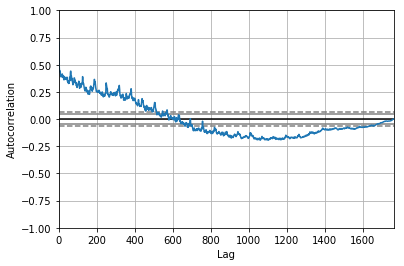

In [8]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(stocks['volume'])

It seems like the volume of trading activity is weakly descendingly correlated with trading volume from the year prior. There aren't any significant non-random peaks in the dataset, so this is good evidence that there isn't much of a time-series pattern to the volume of trade activity over time.

Of course, in this short optional section we're only scratching the surface of what you can do with do with time-series data. There's an entire literature around how to work with time-series variables that we are not discussing here. But these are the basics, and hopefully enough to get you started analyzing your own time-dependent data!

## Exercises


In [9]:
import pandas as pd

crypto = pd.read_csv("../input/all-crypto-currencies/crypto-markets.csv")
crypto = crypto[crypto['name'] == 'Bitcoin']
crypto['date'] = pd.to_datetime(crypto['date'])
crypto.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.500520e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.491160e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.597780e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.542820e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.292190e+09,0.3881,33.32


Try answering the following questions. Click the "Output" button on the cell below to see the answers.

* Time-series variables are really a special case of what other type of variable?
* Why is resampling useful in a data visualization context?
* What is lag? What is autocorrelation?

In [10]:
from IPython.display import HTML

HTML("""
<ol>
<li>Time-series data is really a special case of interval data.</li>
<br/>
<li>Resampling is often useful in data visualization because it can help clean up and denoise our plots by aggregating on a different level.</li>
<br/>
<li>Lag is the time-difference for each observation in the dataset. Autocorrelation is correlation applied to lag.</li>
</ol>
""")

For the exercises that follow, try forking this notebook and replicating the plots that follow. To see the answers, hit the "Input" button below to un-hide the code.

A line chart depicting the `datetime` column in `shelter_outcomes` aggregated by year.

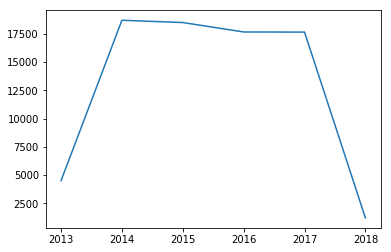

In [11]:
shelter_outcomes['datetime'].value_counts().resample('Y').sum().plot.line()

A lag plot of cryptocurrency (`crypto`) trading `volume`.

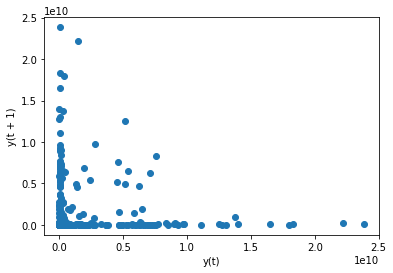

In [12]:
from pandas.plotting import lag_plot

lag_plot(crypto['volume'].sample(500))

An autocorrelation plot of cryptocurrency (`crypto`) trading `volume`.

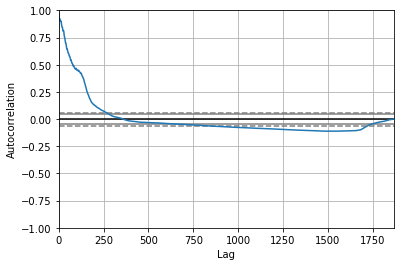

In [13]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(crypto['volume'])